#Read data

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from Kaggle
!kaggle datasets download blastchar/telco-customer-churn


Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
# Unzip the downloaded dataset
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


# =========================
# 📌 1. Import Dependencies
# =========================

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib

sns.set(style="whitegrid")

# ================================
# 📌 2. Load and Inspect the Data
# ================================

In [7]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# ===========================
# 📌 3. Data Cleaning
# ===========================

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [10]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [11]:
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Confirm cleaning
print("Missing values:\n", df.isnull().sum())

Missing values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


/tmp/ipython-input-11-1339985296.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [12]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


# =======================================
# 📌 4. Exploratory Data Analysis (EDA)
# =======================================

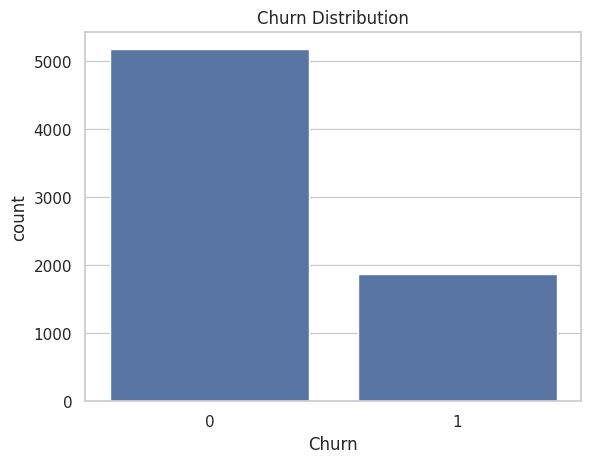

In [13]:
# Target distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

In [14]:
# Churn % Breakdown
print("Churn Rate (%):\n", df['Churn'].value_counts(normalize=True) * 100)

Churn Rate (%):
 Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


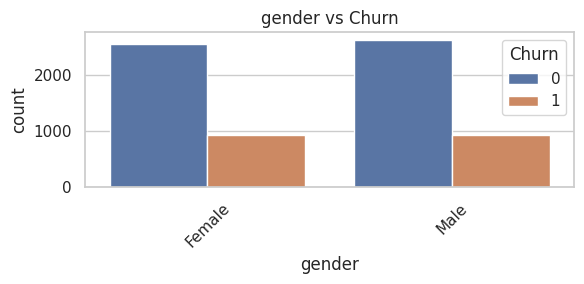

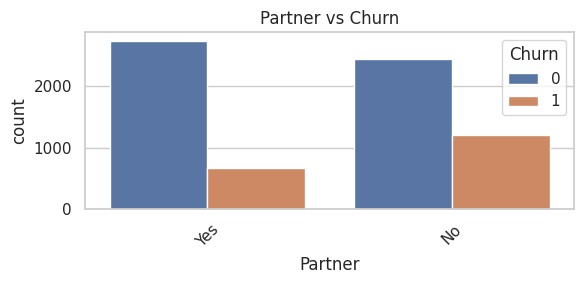

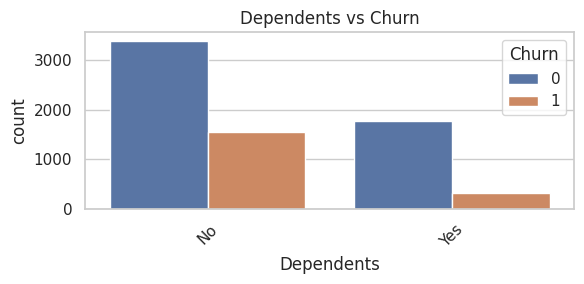

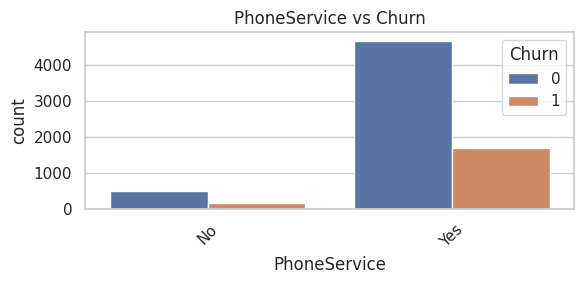

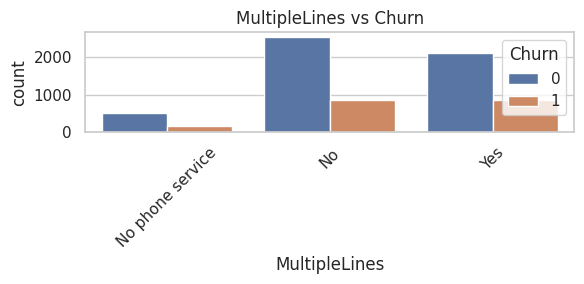

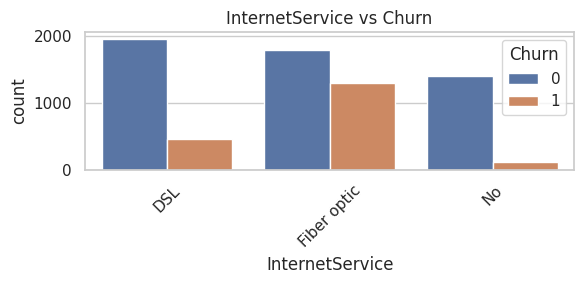

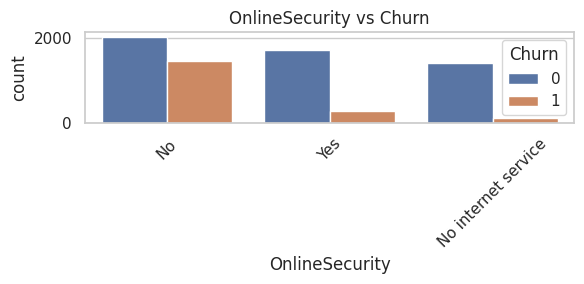

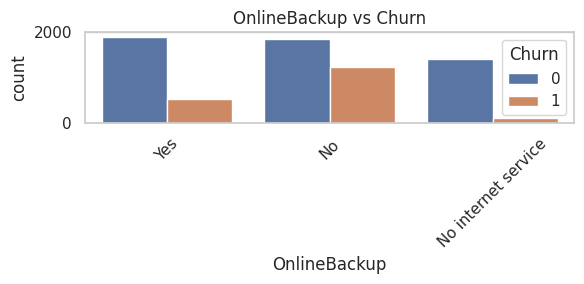

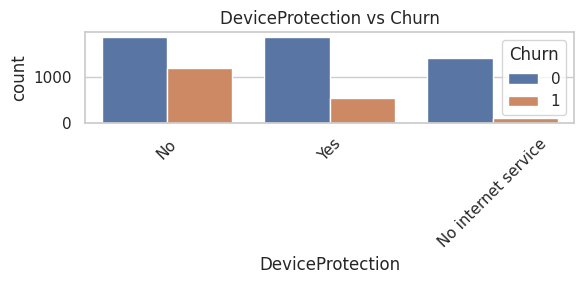

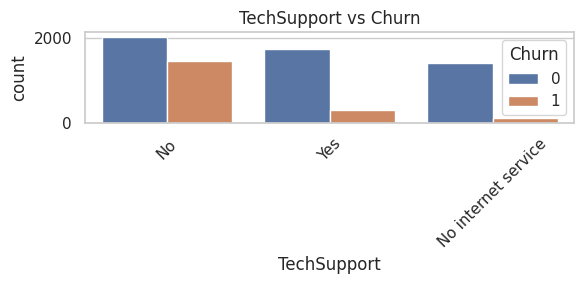

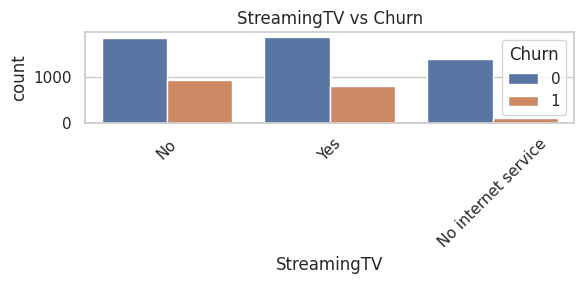

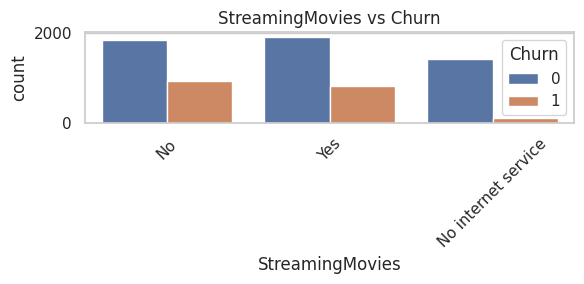

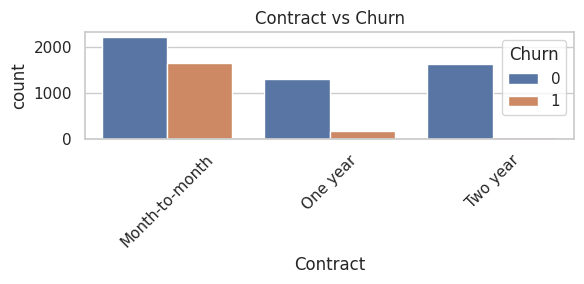

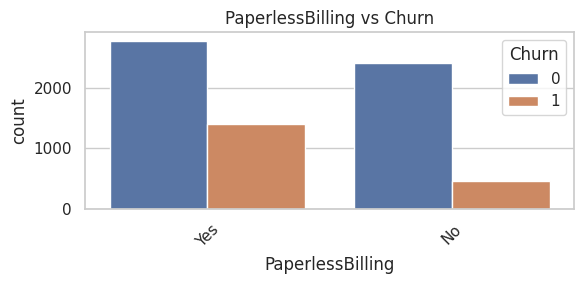

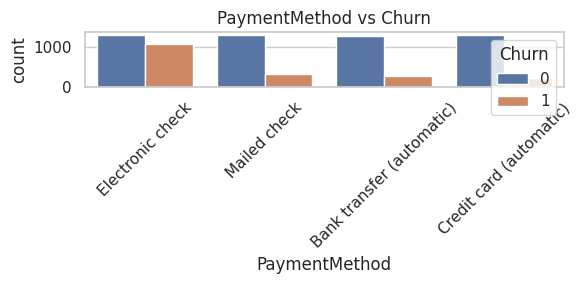

In [15]:
# Visualize categorical features
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Churn")
    plt.tight_layout()
    plt.show()

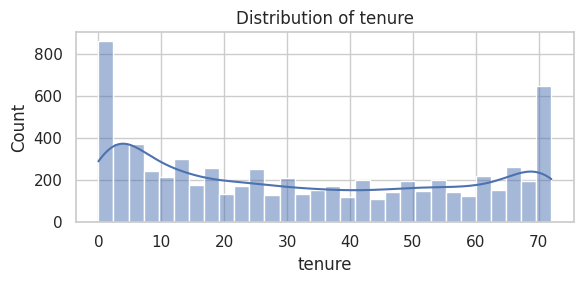

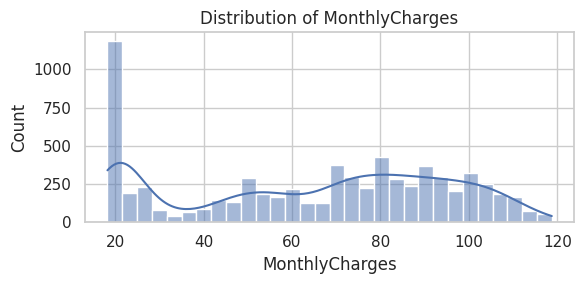

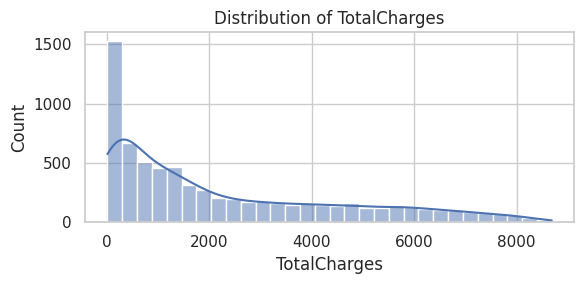

In [16]:
# Visualize numeric features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# =====================================
# 📌 5. Feature Encoding
# =====================================

In [17]:
# Label Encode binary columns
le = LabelEncoder()
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and col != 'Churn']
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode multi-category columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Data shape after encoding:", df.shape)

Data shape after encoding: (7043, 31)


# ======================================
# 📌 6. Train-Test Split + Imbalance Fix
# ======================================

In [18]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


# ================================
# 📌 7. Modeling & Evaluation
# ================================

In [22]:
# Define evaluation function
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_res, y_train_res)
print("🔍 Logistic Regression:")
evaluate(lr, X_test, y_test)

# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)
print("\n🔍 Random Forest:")
evaluate(rf, X_test, y_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.5)
xgb.fit(X_train_res, y_train_res)
print("\n🔍 XGBoost:")
evaluate(xgb, X_test, y_test)

🔍 Logistic Regression:
Confusion Matrix:
 [[818 217]
 [133 241]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1035
           1       0.53      0.64      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409

Precision: 0.5262008733624454
Recall: 0.6443850267379679
ROC AUC Score: 0.7173615954945879

🔍 Random Forest:
Confusion Matrix:
 [[866 169]
 [153 221]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409

Precision: 0.5666666666666667
Recall: 0.5909090909090909
ROC AUC Score: 0.713812

In [23]:
# ==================================
# 📌 8. Feature Importance
# ==================================

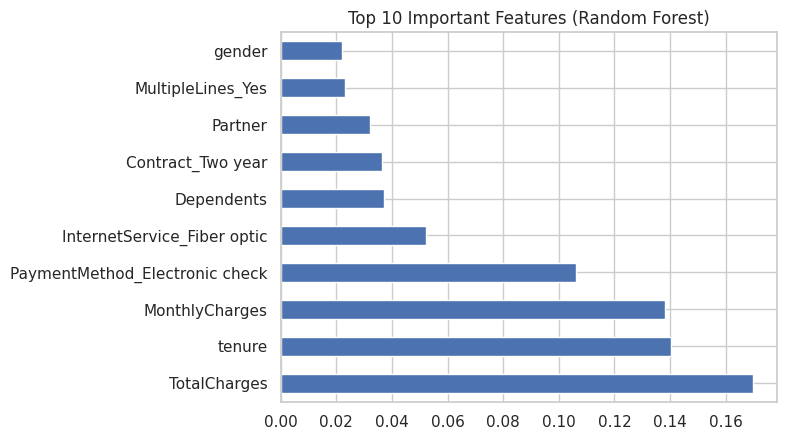

In [24]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

# ==============================
# 📌 9. Save the Best Model
# ==============================

In [25]:
# Save the XGBoost model
joblib.dump(xgb, 'xgboost_churn_model.pkl')
print("✅ Model saved as xgboost_churn_model.pkl")

✅ Model saved as xgboost_churn_model.pkl
